In [1]:
import pandas as pd
from pandas import DataFrame

In [2]:
# déclaration de la variable JAVA_HOME
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
!export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Récupération des tweets en format csv

Récupération des CSV pour les stocker dans des dataframe

In [4]:
datasub1 = pd.read_csv('/content/drive/My Drive/PROJET/Code/data/coronavirus-tweet-id-2020-04-04-11.csv')
datasub2 = pd.read_csv('/content/drive/My Drive/PROJET/Code/data/coronavirus-tweet-id-2020-04-04-12.csv')
datasub3 = pd.read_csv('/content/drive/My Drive/PROJET/Code/data/coronavirus-tweet-id-2020-04-04-13.csv')
datasub4 = pd.read_csv('/content/drive/My Drive/PROJET/Code/data/coronavirus-tweet-id-2020-04-04-14.csv')

Fusion des dataFrame

In [5]:
data = pd.concat([datasub1, datasub2, datasub3, datasub4], ignore_index=True, sort=False)

Les données de la 1ere source sont composé de 131647 tweets venant du 04/04/2020 à 11h,12h,13h, et 14h.

In [6]:
data.shape

(131647, 34)

Récupération du json des données avec géolocalisation pour les stocker dans un dataFrame

In [7]:
data_geo = pd.read_json('/content/drive/My Drive/PROJET/Code/data/geo_2020-04-04FILTRE.json',lines=True)

In [8]:
data_geo.rename(columns={'tweet_id':'id'}, inplace=True)

Les données de la 2eme source (contenant les informations de localisations) sont composé de près de 1500000 tweets.

In [9]:
data_geo.shape

(1492179, 8)

In [75]:
#on copie le dataframe obtenu pour séparer
#ligne a executer pour revenir au DataFrame de départ (pur)
df = data.copy()

# Pré-processing/nettoyage des DataFrame


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

**Nettoyage du Dataframe data**

Vue d'ensemble des valeurs NaN: Les valeurs NaN sont présentes à chaque fois qu'on a du blanc

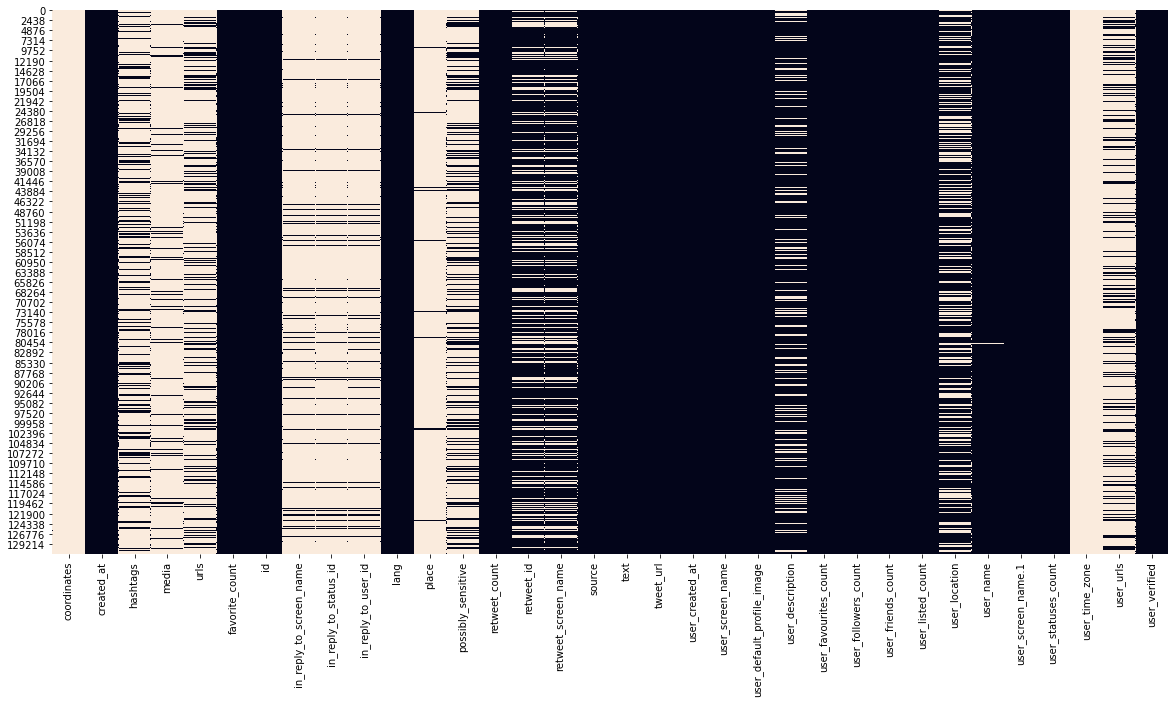

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

Fonction de nettoyage prenant en parametre un DataFrame et retournant un DataFrame qui:
 - Ne garde que les tweets Francais
 - Ne garde que les colonnes qui nous interessent
 - remplace les valeurs NaN par une valeur extreme (pour pouvoir les manipuler)
 - met l'id du tweet d'origine sous le bon format (int)
 - renomme certaines colonnes pour une lecture plus claire
 - crée une nouvelle colonne de booléen indiquant si le tweets est un retweet ou non
 - ajoute une colonne permettant de savoir le numéro du doc (numéro du tweet) dans le dataFrame

In [12]:
def nettoyage(df):
  
  #on garde que les tweets francais
  df = df.drop(df[df.lang != 'fr'].index)
  
  #on garde que les colonnes qui nous interessent
  df = df.drop(['coordinates',
              'media',
              'urls',
              'retweet_count',
              'favorite_count',
              'in_reply_to_screen_name',
              'in_reply_to_status_id',
              'in_reply_to_user_id',
              'possibly_sensitive',
              'retweet_screen_name',
              'source',
              'tweet_url',
              'user_location',
              'created_at',
              'user_created_at',
              'user_screen_name',
              'user_default_profile_image',
              'user_description',
              'user_name',
              'user_statuses_count',
              'user_time_zone',
              'user_urls',
              'user_verified',
              'place',
              'user_favourites_count',
              'user_followers_count',
              'user_friends_count',
              'user_listed_count'],
              axis=1)
  
  #on remplace les NaN par une valeur extreme
  df = df.fillna(-9999)

  #on met l'ID sous le bon type (int)
  df['retweet_id'] = df['retweet_id'].astype(int)

  #on renomme les colonnes
  df.rename(columns={'user_screen_name.1':'user_name','retweet_id':'id_tweet_origine'}, inplace=True)

  #on crée une nouvelle colonne de booléen pour savoir si c'est un retweet ou pas
  df['is_retweet'] = [False if x == -9999 else True for x in df['id_tweet_origine']]

  #ajoute une colonne indiquant le numéro du doc (numéro du tweet)
  df['docno'] = [str(i+1) for i in range(len(df))]


  return df

In [76]:
df = nettoyage(df)

In [19]:
df

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet,docno
39,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True,1
64,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False,2
81,-9999,1246403675062501380,fr,-9999,"Ce sera pour la France en premier, çà changera...",kiddodig,False,3
90,-9999,1246403674714378241,fr,1245863744229396480,RT @blkr00: Le corona il a quand même niquer l...,Szfeifei,True,4
123,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True,5
...,...,...,...,...,...,...,...,...
131503,EspritDeLuxe Supreme street streetstyle style ...,1246449258150182914,fr,-9999,T-shirt Suprême. Tailles : S-XL. #EspritDeLux...,EspritdeLuxe,False,6259
131534,coronavirus,1246449254220083205,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,ana_pinson,True,6260
131538,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True,6261
131574,-9999,1246449266299744256,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,asmaatiquee,True,6262


In [77]:
#ligne de code de test permettant de mettre le docno en index
df = df.set_index('docno')
df

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet
docno,,,,,,,
1,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True
2,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False
3,-9999,1246403675062501380,fr,-9999,"Ce sera pour la France en premier, çà changera...",kiddodig,False
4,-9999,1246403674714378241,fr,1245863744229396480,RT @blkr00: Le corona il a quand même niquer l...,Szfeifei,True
5,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True
...,...,...,...,...,...,...,...
6259,EspritDeLuxe Supreme street streetstyle style ...,1246449258150182914,fr,-9999,T-shirt Suprême. Tailles : S-XL. #EspritDeLux...,EspritdeLuxe,False
6260,coronavirus,1246449254220083205,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,ana_pinson,True
6261,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True


In [27]:
df.columns

Index(['hashtags', 'id', 'lang', 'id_tweet_origine', 'text', 'user_name',
       'is_retweet'],
      dtype='object')

Après tri du dataframe des donénes sans géolocalisation, nous obtenons 6263 tweets avec 7 attributs

**Fusion des dataframe contenant les données de géo avec ceux contenant l'information sur le texte**

In [40]:
data_geo.head(5)

,id,created_at,user_id,geo_source,user_location,geo,place,tweet_locations
0,1246448146000965632,2020-04-04 14:42:50+00:00,389077766,tweet_text,{},{},{},"[{'country_code': 'us', 'state': 'Kentucky', '..."
1,1246448143597817856,2020-04-04 14:42:49+00:00,375795665,tweet_text,{},{},{},"[{'country_code': 'gm', 'state': 'West Coast',..."
2,1246448151613116416,2020-04-04 14:42:51+00:00,152777701,user_location,{'country_code': 'us'},{},{},[]
3,1246448148777783296,2020-04-04 14:42:51+00:00,562460116,user_location,"{'country_code': 'us', 'state': 'New York'}",{},{},"[{'country_code': 'us', 'state': 'Oregon', 'co..."
4,1246448148022808576,2020-04-04 14:42:51+00:00,1192545584315416576,tweet_text,{},{},{},"[{'country_code': 'de', 'state': 'Bavaria', 'c..."


Jointure des deux dataframes:
On veut associer pour chaque tweet déja existant, les informations de la localisation. On fait donc une jointure sur l'id du tweet entre les tweets contenus dans les deux dataframe

In [46]:
df_merged = df.merge(data_geo, left_on='id', right_on='id')

In [30]:
df_merged

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet,created_at,user_id,geo_source,user_location,geo,place,tweet_locations
0,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True,2020-04-04 11:46:05+00:00,1191636425281855488,tweet_text,{},{},{},"[{'country_code': 'ro', 'county': 'Cluj', 'cit..."
1,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False,2020-04-04 11:46:05+00:00,1081192253132025856,tweet_text,{},{},{},"[{'country_code': 'ss', 'state': 'Jonglei'}, {..."
2,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True,2020-04-04 11:46:08+00:00,1211741879206735872,tweet_text,{},{},{},"[{'country_code': 'us', 'state': 'Alabama', 'c..."
3,-9999,1246403682318548992,fr,-9999,Covid-19 : une entreprise française de prêt-à-...,pausefun,False,2020-04-04 11:46:09+00:00,1100708689005215744,user_location,{'country_code': 'fr'},{},{},"[{'country_code': 'co', 'state': 'Cundinamarca..."
4,-9999,1246403691420270592,fr,1246152187463585792,RT @MarcelloTunasi: Le vaccin contre le CORONA...,Riri94650753,True,2020-04-04 11:46:11+00:00,3313711901,tweet_text,{},{},{},"[{'country_code': 'fr', 'state': 'Hauts-de-Fra..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,-9999,1246449253918130176,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,_a2b_,True,2020-04-04 14:47:14+00:00,1089654795252756480,user_location,"{'country_code': 'es', 'state': 'Catalonia', '...",{},{},"[{'country_code': 'ua', 'state': 'Autonomous R..."
2503,COVID19,1246449258028466176,fr,1246123836426334208,RT @DavidKoubbi: Ça fait longtemps que @Sibeth...,FredSarno,True,2020-04-04 14:47:15+00:00,129118550,user_location,"{'country_code': 've', 'state': 'Sucre State'}",{},{},"[{'country_code': 'es', 'state': 'Valencian Co..."
2504,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True,2020-04-04 14:47:15+00:00,1418649908,tweet_text,{},{},{},"[{'country_code': 'de', 'state': 'Brandenburg'..."
2505,-9999,1246449266299744256,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,asmaatiquee,True,2020-04-04 14:47:17+00:00,1229037638096707584,tweet_text,{},{},{},"[{'country_code': 'ua', 'state': 'Autonomous R..."


Le système a réussi à faire la jointure entre les deux dataframe sur l'id du tweet. Il a retourné un total de 2507 tweets.

In [47]:
df_merged = df_merged.assign(country="-9999") #on crée une colonne country qui va contenir l'information de la localisation normalisée

In [48]:
#cette boucle permet d'attribuer les valeurs à la nouvelle colonne country: elle prend les initiales du pays et le met dans cette nouvelle colonne

for i in range(df_merged.shape[0]):
  temp = df_merged['user_location'][i]
  if temp:
    df_merged.loc[i,'country'] = df_merged['user_location'][i]['country_code']

In [49]:
#on a notre colonne normalisée, on peut desormais supprimer les colonnes qui ne nous interessent plus
df_merged = df_merged.drop(['geo','place','tweet_locations','user_location'],axis=1)

In [37]:
df_merged

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet,created_at,user_id,geo_source,country
0,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True,2020-04-04 11:46:05+00:00,1191636425281855488,tweet_text,NaN
1,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False,2020-04-04 11:46:05+00:00,1081192253132025856,tweet_text,NaN
2,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True,2020-04-04 11:46:08+00:00,1211741879206735872,tweet_text,NaN
3,-9999,1246403682318548992,fr,-9999,Covid-19 : une entreprise française de prêt-à-...,pausefun,False,2020-04-04 11:46:09+00:00,1100708689005215744,user_location,fr
4,-9999,1246403691420270592,fr,1246152187463585792,RT @MarcelloTunasi: Le vaccin contre le CORONA...,Riri94650753,True,2020-04-04 11:46:11+00:00,3313711901,tweet_text,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2502,-9999,1246449253918130176,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,_a2b_,True,2020-04-04 14:47:14+00:00,1089654795252756480,user_location,es
2503,COVID19,1246449258028466176,fr,1246123836426334208,RT @DavidKoubbi: Ça fait longtemps que @Sibeth...,FredSarno,True,2020-04-04 14:47:15+00:00,129118550,user_location,ve
2504,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True,2020-04-04 14:47:15+00:00,1418649908,tweet_text,NaN
2505,-9999,1246449266299744256,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,asmaatiquee,True,2020-04-04 14:47:17+00:00,1229037638096707584,tweet_text,NaN


In [ ]:
df.shape

(1510, 9)

In [ ]:
df

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet,created_at,user_id,geo_source,country
0,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True,2020-04-04 11:46:05+00:00,1191636425281855488,tweet_text,-9999
1,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False,2020-04-04 11:46:05+00:00,1081192253132025856,tweet_text,-9999
2,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True,2020-04-04 11:46:08+00:00,1211741879206735872,tweet_text,-9999
3,-9999,1246403682318548992,fr,-9999,Covid-19 : une entreprise française de prêt-à-...,pausefun,False,2020-04-04 11:46:09+00:00,1100708689005215744,user_location,fr
4,-9999,1246403691420270592,fr,1246152187463585792,RT @MarcelloTunasi: Le vaccin contre le CORONA...,Riri94650753,True,2020-04-04 11:46:11+00:00,3313711901,tweet_text,-9999
...,...,...,...,...,...,...,...,...,...,...,...
2502,-9999,1246449253918130176,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,_a2b_,True,2020-04-04 14:47:14+00:00,1089654795252756480,user_location,es
2503,COVID19,1246449258028466176,fr,1246123836426334208,RT @DavidKoubbi: Ça fait longtemps que @Sibeth...,FredSarno,True,2020-04-04 14:47:15+00:00,129118550,user_location,ve
2504,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True,2020-04-04 14:47:15+00:00,1418649908,tweet_text,-9999
2505,-9999,1246449266299744256,fr,1246126510886576128,RT @binkszdn: mais pk les blancs à chèques foi...,asmaatiquee,True,2020-04-04 14:47:17+00:00,1229037638096707584,tweet_text,-9999


On sauvegarde (optionnellement) le fichier nouveau fichier csv propre
- se mettre dans le dossier partager
- Sauvegarder le fichier csv

In [ ]:
#cd drive/MyDrive/PROJET/

[Errno 2] No such file or directory: 'drive/MyDrive/PROJET/'
/content/drive/MyDrive/PROJET


In [ ]:
df_merged.to_csv('coronavirus-tweet-id-2020-04-04-12_CLEAR.csv', encoding='utf-8')

# Indexation avec Terrier

Installation de l'environnement

In [50]:
#installation de pyterrier avec pip
!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier

  Cloning https://github.com/terrier-org/pyterrier.git to /tmp/pip-install-gfrgx2wv/python-terrier
  Running command git clone -q https://github.com/terrier-org/pyterrier.git /tmp/pip-install-gfrgx2wv/python-terrier
     |████████████████████████████████| 1.1MB 8.6MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 163kB 24.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 1.8MB 33.2MB/s 
     |████████████████████████████████| 645kB 20.2MB/s 
     |████████████████████████████████| 133kB 39.3MB/s 
     |████████████████████████████████| 5.5MB 27.6MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.5.0-cp37-none-any.whl size=91584 sha256=eeb39a8e802441daa00a3f3a330c3d638e1a4063fbf0da5137d92be418e148bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_45518_/wheels/cc/bb/69/836d846a92c787b35ca6478119c0033762ab2b95d866e

In [51]:
#Initialization de JVM
import pyterrier as pt
if not pt.started():
  pt.init()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


terrier-assemblies 5.4  jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.5  jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.5.0 has loaded Terrier 5.4 (built by craigm on 2021-01-16 14:17)


Création **ET REINITIALISATION** du dossier pour le stockage des indexes /content/drive/MyDrive/PROJET

In [52]:
!rm -rf /content/drive/MyDrive/PROJET/pd_index
pd_indexer = pt.DFIndexer("/content/drive/My Drive/PROJET/pd_index")

Indexation sur le texte

In [53]:
indexref = pd_indexer.index(df["text"],df['id'].astype(str))

In [54]:
#statistiques de l'index
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 6263
Number of terms: 12284
Number of postings: 115822
Number of fields: 0
Number of tokens: 126681
Field names: []
Positions:   false



In [55]:
#lecture d'un index déjà crée
indexref2 = pt.autoclass("org.terrier.querying.IndexRef").of(os.path.join("/content/drive/MyDrive/PROJET/pd_index", "data.properties"))

Recherche dans l'index

In [56]:
def recherche_index(index, model, mot_cle):
  return pt.BatchRetrieve(index, wmodel=model, metadata=['id']).search(mot_cle)

In [57]:
recherche_index(indexref,'TF_IDF', 'covid')

,qid,docid,id,rank,score,query
0,1,4201,1246426365508964359,0,2.666365,covid
1,1,2339,1246409328413888512,1,2.520554,covid
2,1,773,1246397428967841793,2,2.520554,covid
3,1,2397,1246409429706301441,3,2.440054,covid
4,1,5250,1246437627395481606,4,2.440054,covid
...,...,...,...,...,...,...
761,1,4956,1246437048724094979,761,1.088722,covid
762,1,1255,1246402634262683648,762,1.061911,covid
763,1,445,1246396850233638913,763,1.048995,covid
764,1,5904,1246443914271379457,764,1.000327,covid


LA PARTIE SUR LA MISE EN OEUVRE DE LA PERTINENCE D'UN UTILISATEUR NE FONCTIONNE PAS

**Mise en oeuvre de la pertinence d'un utilisateur**

Nous devons calculer la pertinence des utilisateurs pour une requete donnée




In [ ]:
data

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet
docno,,,,,,,
1,Lechypre BFMTV,1246403666627702784,fr,1246403416844369920,"RT @Brevesdepresse: ⚡🇲🇫|🇨🇳VIDÉO - ""Ils enterre...",radiolondres6,True
2,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False
3,-9999,1246403675062501380,fr,-9999,"Ce sera pour la France en premier, çà changera...",kiddodig,False
4,-9999,1246403674714378241,fr,1245863744229396480,RT @blkr00: Le corona il a quand même niquer l...,Szfeifei,True
5,-9999,1246403678887653376,fr,1246383231144005632,RT @cltoxine: Avant de traduire ou de lire rée...,MargauxLeroy10,True
...,...,...,...,...,...,...,...
6259,EspritDeLuxe Supreme street streetstyle style ...,1246449258150182914,fr,-9999,T-shirt Suprême. Tailles : S-XL. #EspritDeLux...,EspritdeLuxe,False
6260,coronavirus,1246449254220083205,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,ana_pinson,True
6261,coronavirus,1246449258670231552,fr,1246447605640507392,RT @Conflits_FR: 🇫🇷 Lutte contre le #coronavir...,_azzdoooo_,True


In [ ]:
import numpy as np

In [ ]:
for i in data:
  print(i)

hashtags
id
lang
id_tweet_origine
text
user_name
is_retweet


In [ ]:
def calculerMatriceTweets(data):
  dim = data.shape[0]
  matrice = np.zeros([dim,dim])
  for i in range(dim):
    for j in range(dim):
      for i in data:
        if i['id_tweet_origine'] != -9999:
          matrice[i][j] = 1
  return matrice

calculerMatriceTweets(data)


TypeError: ignored

# Classification

Import des outils nécéssaires

In [58]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer #import du module CountVectorizer pour creer la matrice mot document
from sklearn.decomposition import LatentDirichletAllocation #import du module LDA de scikot learn

installation de l'outil générant les mot vides francais

In [59]:
pip install stop-words 

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=381fdbd2f13e022c67bd76f408c113e19b93cdb5f071b78ec28ae0226ccf21cc
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [60]:
import stop_words as sw

In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

On attrape les mots vides Francais et on ajoute https (certains textes contiennent des liens, et https apparaissait dans la matrice mot document, c'est pourquoi nous l'enlevons

In [62]:
french_stop_words = sw.get_stop_words('fr') + ['https','plus','pendant','plusjamaisca','voici','durant','s_assbague',"c'est"]

In [63]:
french_stop_words

['a',
 'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'alors',
 'as',
 'au',
 'aucun',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autre',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayez',
 'ayons',
 'bon',
 'car',
 'ce',
 'ceci',
 'cela',
 'ces',
 'cet',
 'cette',
 'ceux',
 'chaque',
 'ci',
 'comme',
 'comment',
 'd',
 'dans',
 'de',
 'dedans',
 'dehors',
 'depuis',
 'des',
 'deux',
 'devoir',
 'devrait',
 'devrez',
 'devriez',
 'devrions',
 'devrons',
 'devront',
 'dois',
 'doit',
 'donc',
 'dos',
 'droite',
 'du',
 'dès',
 'début',
 'dù',
 'elle',
 'elles',
 'en',
 'encore',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'faire',
 'fais',
 'faisez',
 'fait',
 'faites',
 'fois',
 'font',
 'force',
 'furent',


 *Quelques fonctions:*
 - *tokenize: permet de filtrer le texte encore un peu plus*
 - *plot_top_words: fonction permettant d'affichier les graphiques des top mots*

In [64]:
def tokenize(text):
  tokens = [mot for mot in nltk.word_tokenize(text) if (len(mot)>3 and len(mot.strip('Xx/')) > 2)]
  return tokens

In [65]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_topic, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [91]:
df = df.drop(df[df.is_retweet == 'true'].index)
df

,hashtags,id,lang,id_tweet_origine,text,user_name,is_retweet
docno,,,,,,,
2,-9999,1246403666287955968,fr,-9999,nique ce pouvoir. mets son peuple en danger po...,amelineee2,False
3,-9999,1246403675062501380,fr,-9999,"Ce sera pour la France en premier, çà changera...",kiddodig,False
6,-9999,1246403674605342725,fr,-9999,Avenge our sister https://t.co/d10paqDZrr,PoppyNova1,False
7,coronavirus,1246403686722605058,fr,-9999,Le #coronavirus menace de nombreux clubs amate...,francetvsport,False
8,-9999,1246403682318548992,fr,-9999,Covid-19 : une entreprise française de prêt-à-...,pausefun,False
...,...,...,...,...,...,...,...
6234,-9999,1246449199849172997,fr,-9999,"Demain, les années 1930 ou le Moyen Age… https...",Bohemond,False
6239,-9999,1246449215401852928,fr,-9999,J'adresse ici ma solidarité à toutes les perso...,DialloA35715704,False
6241,coronavirus,1246449216366526467,fr,-9999,COVID-19: la crise génère de la détresse psych...,plaroch,False


Extraction du texte simple par document

In [92]:
textes = [x for x in df['text']]

In [93]:
for i in range(len(textes)):
  textes[i] = textes[i].lower()
  textes[i] = textes[i].replace('covid-19','covid')
  textes[i] = textes[i].replace('covid19','covid')
  

Création de la matrice mot-document

In [126]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=3,
                                tokenizer=tokenize, #on passe ici la fonction de filtre tokenize
                                stop_words=french_stop_words) #et ici on adopte les stop words francais

In [127]:
tf = tf_vectorizer.fit_transform(textes)

Charge le LDA

In [70]:
def calcul_LDA(n_topic,tf):
  lda = LatentDirichletAllocation(n_components=n_topic, max_iter=10, random_state=0)
  lda.fit(tf)
  return lda

Fonction de calcul de perplexité pour chaque n_topic

In [71]:
def calcul_perpexite(n_test_topics,tf):
  perp = np.empty([n_test_topics-2])
  for i in range(2,n_test_topics):
    lda = LatentDirichletAllocation(n_components=i, random_state=0)
    lda.fit(tf)
    perp[i-2] = lda.perplexity(tf)
  return perp

In [128]:
y = calcul_perpexite(10,tf) #on fait un test avec entre 1 et 10 topics

<function matplotlib.pyplot.show>

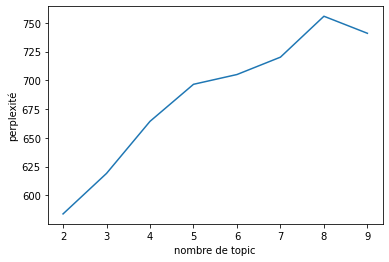

In [129]:
x = np.array([2,3,4,5,6,7,8,9])
plt.plot(x,y)
plt.xlabel("nombre de topic")
plt.ylabel("perplexité")
plt.show

In [85]:
n_topic = y.argmin()+2 #on récupère le nombre de topic optimal

In [86]:
lda = calcul_LDA(n_topic,tf)

In [87]:
tf_feature_names = tf_vectorizer.get_feature_names() #attrape tous les mots finaux detectés dans la matrice mot document

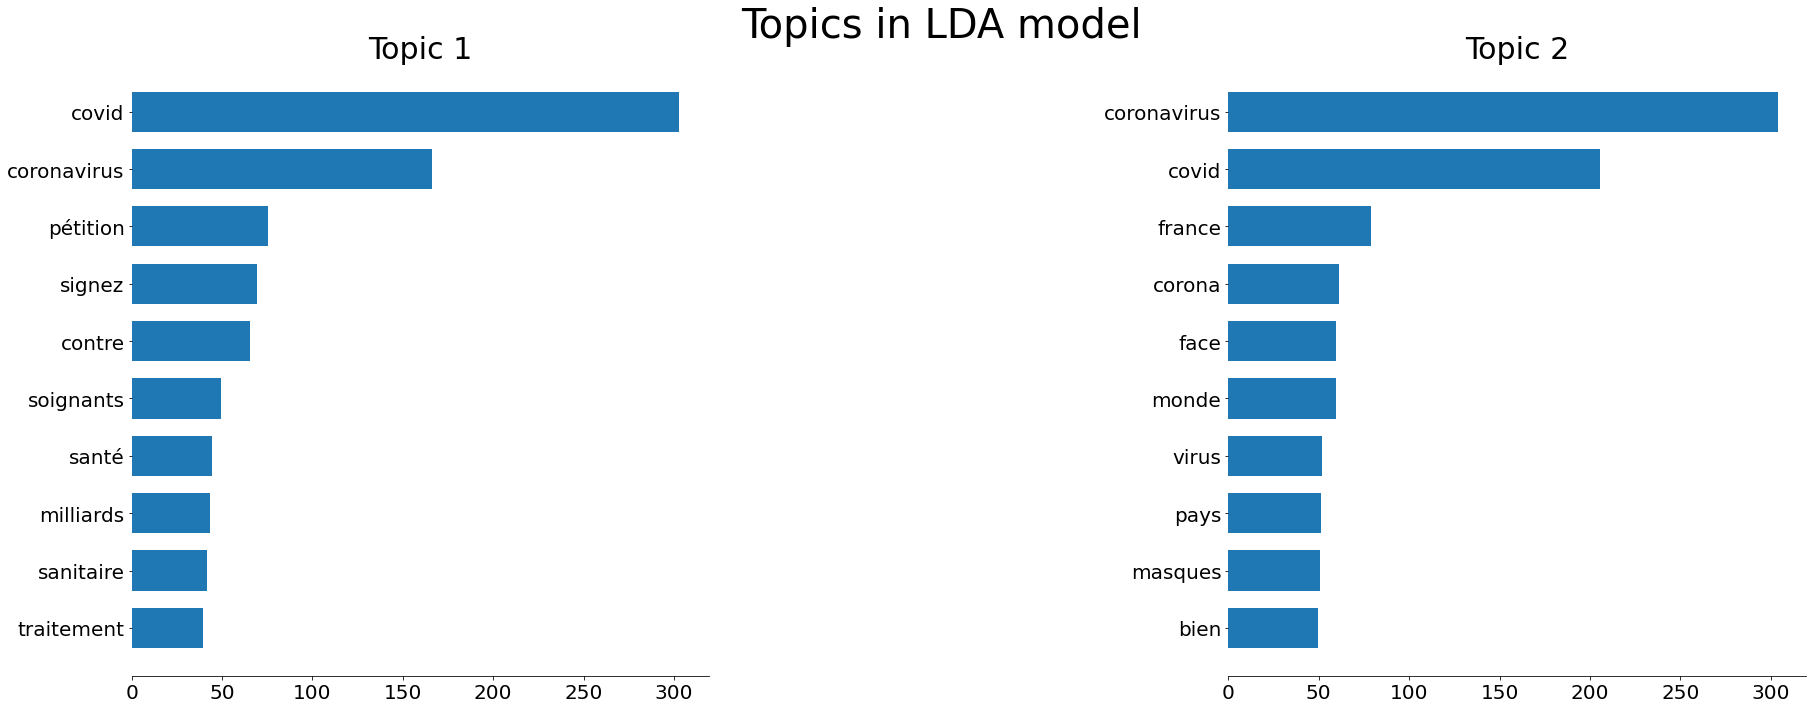

In [88]:
plot_top_words(lda, tf_feature_names, 10, 'Topics in LDA model') #affiche les graphes

Création d'un graphique de mots en fonction de leurs fréquence

In [ ]:
!python -m spacy download fr_core_news_sm

In [121]:
import string
from gensim.utils import simple_preprocess
import fr_core_news_sm
nlp = fr_core_news_sm.load(disable=['parser', 'ner'])

def process_words(texts, stop_words=french_stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    

    punctuation = list(string.punctuation) 
    # remove stopwords, short tokens and letter accents 
    stop_words.extend(punctuation)
    #stop_words.extend([" ", ' ','','https',"alors","lors"])
    texts = [[word for word in simple_preprocess(str(doc), deacc=False, min_len=3) if word not in stop_words and len(word)!=0] for doc in texts if len(doc)!=0]

    
    texts_out = []

    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=False, min_len=3) if word not in stop_words and len(word)!=0] for doc in texts_out if len(doc)!=0]    
    
    return texts_out

In [123]:
textes_final = process_words(textes)

In [ ]:
res = []
for i in textes_final:
  res.append(" ".join(i))


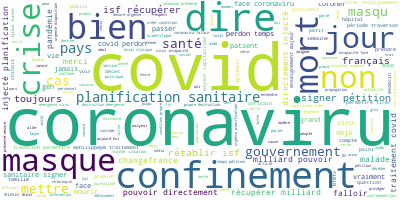

In [131]:
# Import the wordcloud library
from wordcloud import WordCloud
papers=data
# Join the different processed titles together.
long_string = ','.join(res)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
long_string=wordcloud.process_text(long_string)
#print(long_string)
# Generate a word cloud
wordcloud.fit_words(long_string)
# Visualize the word cloud
wordcloud.to_image()